In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2ycbcr, ycbcr2rgb
import time
import pandas as pd
from tqdm import tqdm
import random
import seaborn as sns

from classic_algos.lanczos import SR_lanczos
from classic_algos.bicubic_interpolation import SR_bicubic
from src.models import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DATA_DIR = Path.home() / '.data'

TEST_DIR = DATA_DIR / 'UCMerced_LandUse_Split' / 'test'
VAL_DIR = DATA_DIR / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = DATA_DIR

In [4]:
def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    return 10 * np.log10(1. / (mse + 1e-20))

def ERGAS(img_gt, img_sr, scale):
    img_gt = img_gt.astype(np.float64)
    img_sr = img_sr.astype(np.float64)
    diff = img_gt - img_sr
    rmse_per_band = np.sqrt(np.mean(diff ** 2, axis=(0, 1)))
    mean_per_band = np.mean(img_gt, axis=(0, 1))
    mean_per_band[mean_per_band == 0] = 1e-10

    sum_sq = np.sum((rmse_per_band / mean_per_band) ** 2)
    return 100 * (1 / scale) * np.sqrt((1 / img_gt.shape[2]) * sum_sq)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
def get_model_prediction(lr_rgb, model_name, model, scale):
    H, W, C = lr_rgb.shape
    target_h, target_w = H * scale, W * scale

    mode = 'y' if model_name.startswith('y_') else 'rgb'

    with torch.no_grad():
        if mode == 'rgb':
            # (H,W,C) -> (1,C,H,W)
            lr_tensor = torch.from_numpy(np.transpose(lr_rgb, (2, 0, 1))).unsqueeze(0).float().to(device)
            sr_tensor = model(lr_tensor)

            # (1,C,H,W) -> (H,W,C)
            sr_rgb = sr_tensor.squeeze().cpu().numpy()
            sr_rgb = np.transpose(sr_rgb, (1, 2, 0))
            return np.clip(sr_rgb, 0, 1)

        elif mode == 'y':
            ycbcr = rgb2ycbcr(lr_rgb)
            lr_y = ycbcr[:, :, 0] / 255.0

            lr_y_tensor = torch.from_numpy(lr_y).unsqueeze(0).unsqueeze(0).float().to(device)
            sr_y_tensor = model(lr_y_tensor)

            sr_y = sr_y_tensor.squeeze().squeeze().cpu().numpy()
            sr_y = sr_y * 255.0

            #take color from bicubic
            sr_bicubic_rgb = SR_bicubic(lr_rgb, target_h, target_w, preserve_range=True, output_dtype=np.float32)
            sr_bicubic_ycbcr = rgb2ycbcr(sr_bicubic_rgb)
            sr_cb = sr_bicubic_ycbcr[:, :, 1]
            sr_cr = sr_bicubic_ycbcr[:, :, 2]

            h_y, w_y = sr_y.shape
            sr_cb = sr_cb[:h_y, :w_y]
            sr_cr = sr_cr[:h_y, :w_y]

            sr_ycbcr = np.stack([sr_y, sr_cb, sr_cr], axis=2)
            sr_rgb = ycbcr2rgb(sr_ycbcr)

            return np.clip(sr_rgb, 0, 1)


In [10]:
models = {}

y_fsrcnn = FSRCNN_Y().to(device)
y_fsrcnn.load_state_dict(torch.load(MODEL_DIR / 'y_fsrcnn_best_model.pth', map_location=device))
models['y_fsrcnn'] = y_fsrcnn

y_ressr = ResSR(num_channels=1).to(device)
y_ressr.load_state_dict(torch.load(MODEL_DIR / 'y_ressr_best_model.pth', map_location=device))
models['y_ressr'] = y_ressr

rgb_ressr = ResSR(num_channels=3).to(device)
rgb_ressr.load_state_dict(torch.load(MODEL_DIR / 'rgb_ressr_best_model.pth', map_location=device))
models['rgb_ressr'] = rgb_ressr

y_rcan = RCAN(num_channels=1).to(device)
y_rcan.load_state_dict(torch.load(MODEL_DIR / 'y_rcan_best_model.pth', map_location=device))
models['y_rcan'] = y_rcan

rgb_rcan = RCAN(num_channels=3).to(device)
rgb_rcan.load_state_dict(torch.load(MODEL_DIR / 'rgb_rcan_best_model.pth', map_location=device))
models['rgb_rcan'] = rgb_rcan

In [24]:
results = []
file_paths = list(TEST_DIR.rglob("*.tif"))
SCALE = 2
for img_path in tqdm(file_paths):
    class_name = img_path.parent.name

    with rasterio.open(img_path) as src:
        hr = src.read()
    # (C, H, W) -> (H, W, C), float32 [0..1]
    hr = np.transpose(hr, (1, 2, 0)).astype(np.float32) / 255.0

    H, W, _ = hr.shape
    H_new = H - (H % SCALE)
    W_new = W - (W % SCALE)
    hr = hr[:H_new, :W_new, :]

    lr_h, lr_w = H_new // SCALE, W_new // SCALE
    lr = SR_bicubic(hr, lr_h, lr_w, preserve_range=True, output_dtype=np.float32)

    methods_list = [
        ('Bicubic', None),
        ('Lanczos', None)
    ]

    for name in models.keys():
        methods_list.append((name, models[name]))

    for method_name, model in methods_list:
        torch.cuda.synchronize()
        start_time = time.perf_counter()

        if method_name == 'Bicubic':
            sr = SR_bicubic(lr, H_new, W_new, preserve_range=True, output_dtype=np.float32)
        elif method_name == 'Lanczos':
            sr = SR_lanczos(lr, H_new, W_new, preserve_range=True, output_dtype=np.float32)
        else:
            sr = get_model_prediction(lr, method_name, model, SCALE)

        torch.cuda.synchronize()
        end_time = time.perf_counter()
        inference_time = (end_time - start_time) * 1000


        sr_y = rgb2ycbcr(sr)[:, :, 0] / 255.0
        hr_y = rgb2ycbcr(hr)[:, :, 0] / 255.0

        #delete borders
        shave = SCALE
        hr_y = hr_y[shave:-shave, shave:-shave]
        sr_y = sr_y[shave:-shave, shave:-shave]

        p = PSNR(hr_y, sr_y)
        s = ssim(hr_y, sr_y, data_range=1.0)
        e = ERGAS(hr, sr, SCALE)
        fps = 1.0 / (end_time - start_time + 1e-10)

        results.append({
            'File': img_path.name,
            'Class': class_name,
            'Method': method_name,
            'PSNR': p,
            'SSIM': s,
            'ERGAS': e,
            'Time_ms': inference_time,
            'FPS': fps
        })

df = pd.DataFrame(results)

print(df.head())

  0%|          | 0/210 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/mnt/c/Users/nicol/OneDrive/work/super-resolution/classic_algos/lanczos.py:4: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x))
100%|██████████| 210/210 [00:37<00:00,  5.63it/s]

                 File         Class     Method       PSNR      SSIM     ERGAS  \
0  agricultural42.tif  agricultural    Bicubic  37.437710  0.963957  1.348210   
1  agricultural42.tif  agricultural    Lanczos  37.793297  0.967473  1.299914   
2  agricultural42.tif  agricultural   y_fsrcnn  36.998672  0.960414  1.425582   
3  agricultural42.tif  agricultural    y_ressr  38.478462  0.970782  1.207859   
4  agricultural42.tif  agricultural  rgb_ressr  38.428818  0.970605  1.218050   

     Time_ms        FPS  
0  39.999362  25.000399  
1  40.561189  24.654110  
2  79.245076  12.619081  
3  96.121807  10.403466  
4  64.125266  15.594477  


In [20]:
summary_df = df.groupby('Method').agg({
    'PSNR': ['mean', 'std'],
    'SSIM': ['mean', 'std'],
    'ERGAS': ['mean'],
    'Time_ms': ['mean'],
    'FPS': ['mean']
}).round(4)
print(summary_df)

                PSNR            SSIM           ERGAS  Time_ms       FPS
                mean     std    mean     std    mean     mean      mean
Method                                                                 
Bicubic    31.930300  5.7136  0.8991  0.0719  4.0396   5.1581  197.5189
Lanczos    32.009499  5.8919  0.8971  0.0764  4.0596  11.2325   89.9506
rgb_rcan   32.947399  5.6816  0.9115  0.0648  3.6407  14.9819   68.7333
rgb_ressr  32.850399  5.6990  0.9099  0.0672  3.6824   8.8153  122.9658
y_fsrcnn   31.813801  5.5740  0.8960  0.0728  4.0879  12.9035   78.3352
y_rcan     32.893700  5.6885  0.9104  0.0665  3.6680  20.3129   49.8528
y_ressr    32.786598  5.7015  0.9090  0.0680  3.7106  14.4445   71.3733


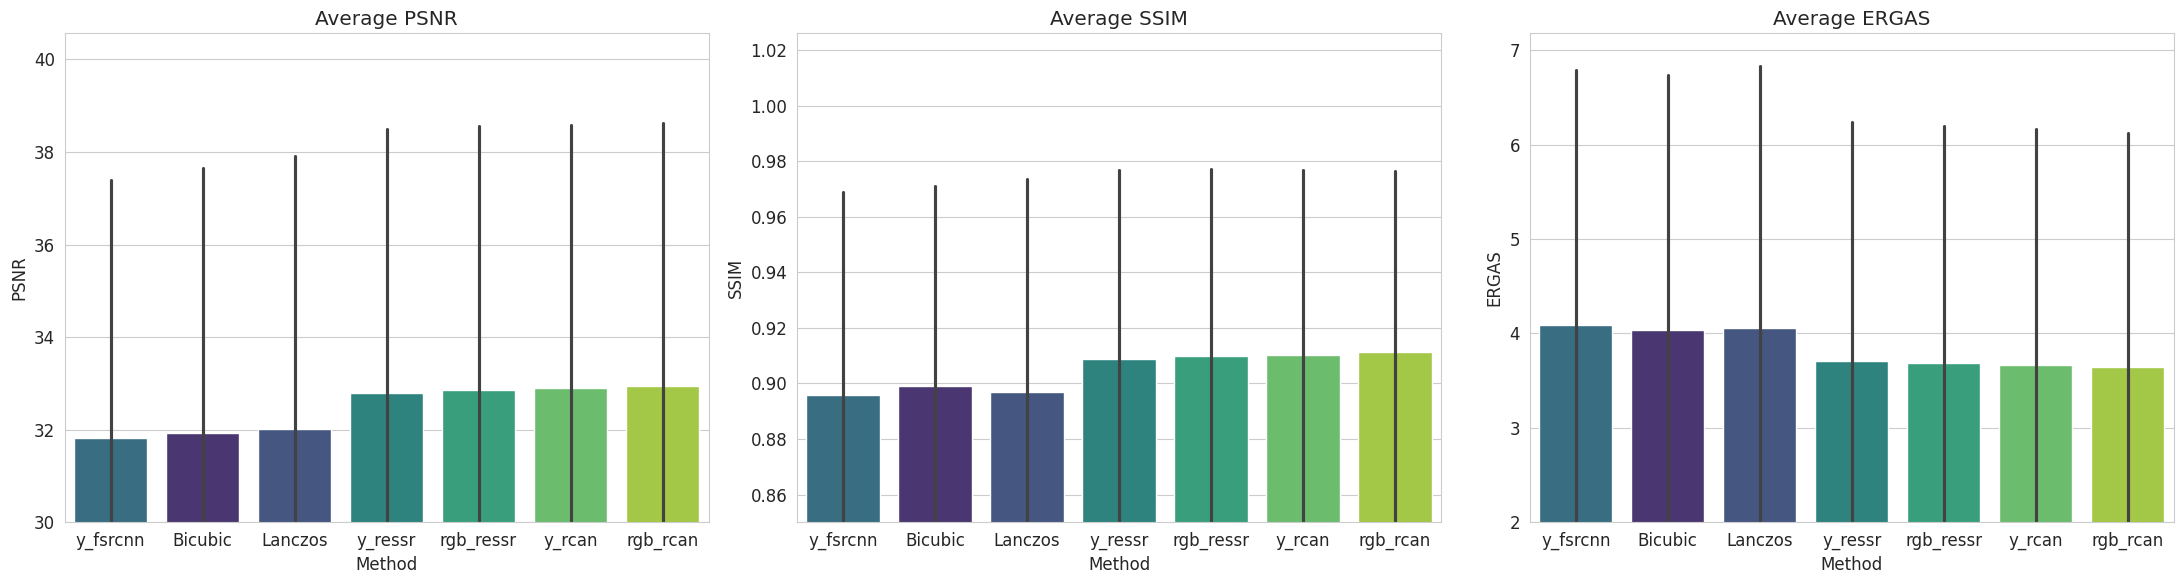

In [74]:
order = df.groupby('Method')['PSNR'].mean().sort_values().index.tolist()


fig, axes = plt.subplots(1, 3, figsize=(22, 6))

sns.barplot(
    data=df,
    x='Method',
    y='PSNR',
    order=order,
    ax=axes[0],
    palette='viridis',
    errorbar='sd',
    hue='Method',
    legend=False
)
axes[0].set_title('Average PSNR')
axes[0].set_ylim(bottom=30)

sns.barplot(
    data=df,
    x='Method',
    y='SSIM',
    order=order,
    ax=axes[1],
    palette='viridis',
    errorbar='sd',
    hue='Method',
    legend=False
)
axes[1].set_title('Average SSIM')
axes[1].set_ylim(bottom=0.85)

sns.barplot(
    data=df,
    x='Method',
    y='ERGAS',
    order=order,
    ax=axes[2],
    palette='viridis',
    errorbar='sd',
    hue='Method',
    legend=False
)
axes[2].set_title('Average ERGAS')
axes[2].set_ylim(bottom=2)

plt.tight_layout()
plt.show()

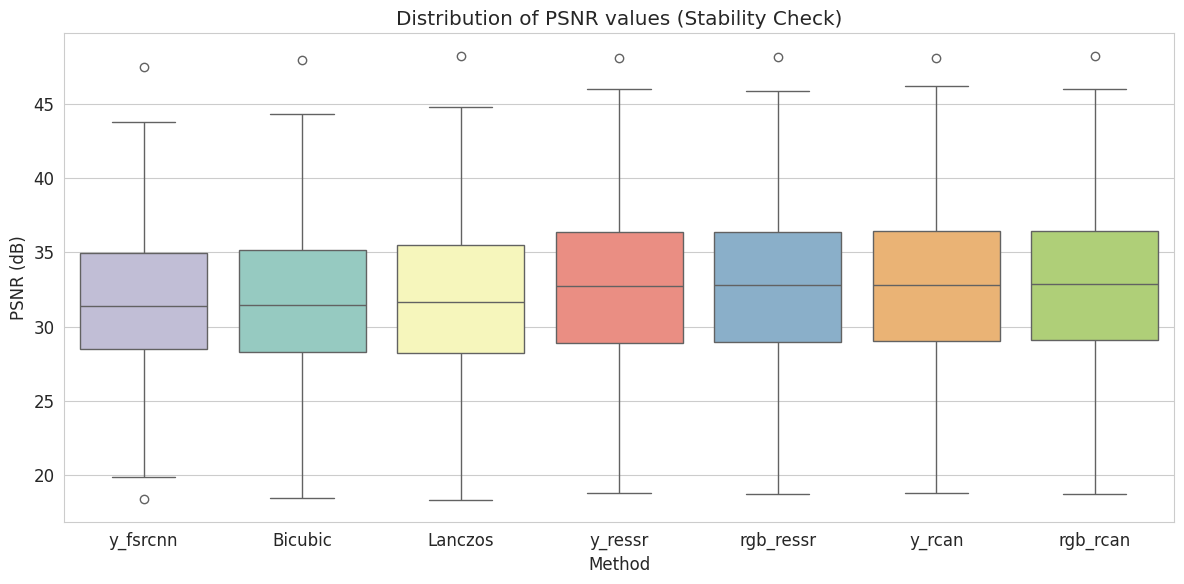

In [51]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df,
            x='Method',
            y='PSNR',
            order=order,
            palette='Set3',
            hue='Method',
            legend=False)
plt.title('Distribution of PSNR values ')
plt.ylabel('PSNR (dB)')
plt.tight_layout()
plt.show()

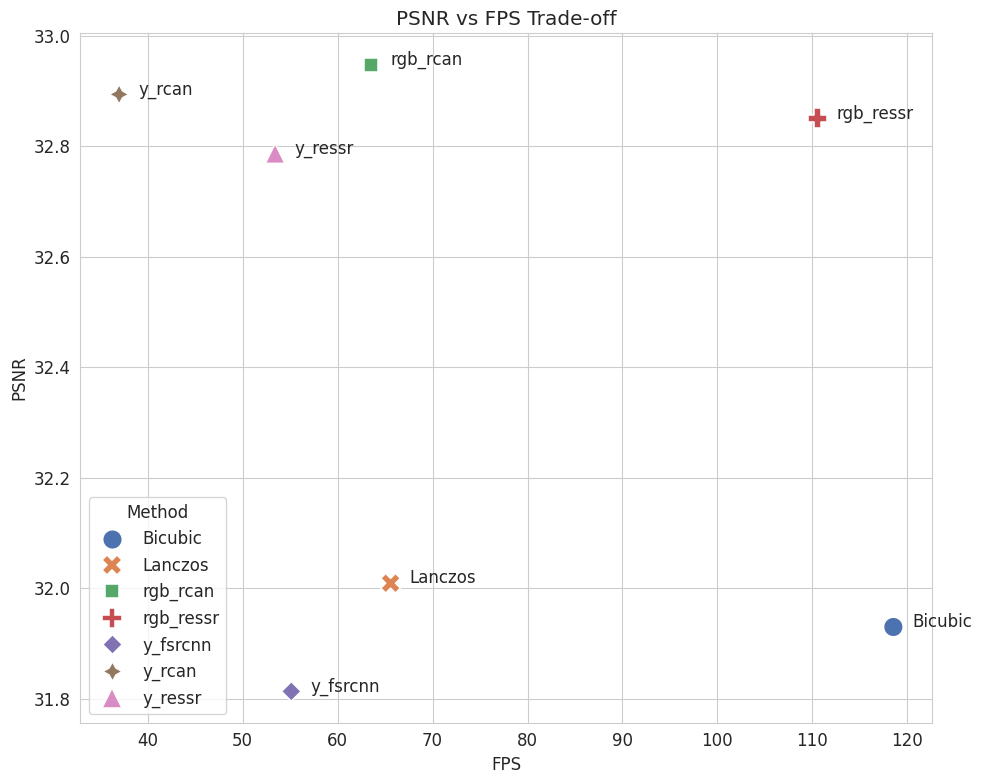

In [56]:
mean_data = df.groupby('Method')[['PSNR', 'FPS']].mean().reset_index()

plt.figure(figsize=(10, 8))

sns.scatterplot(data=mean_data,
                x='FPS',
                y='PSNR',
                hue='Method',
                style='Method',
                s=200,
                palette='deep')

for i in range(mean_data.shape[0]):
    plt.text(
        mean_data.FPS[i]+2,
        mean_data.PSNR[i],
        mean_data.Method[i],
    )

plt.title('PSNR vs FPS Trade-off')
plt.xlabel('FPS')
plt.ylabel('PSNR')

plt.tight_layout()
plt.show()

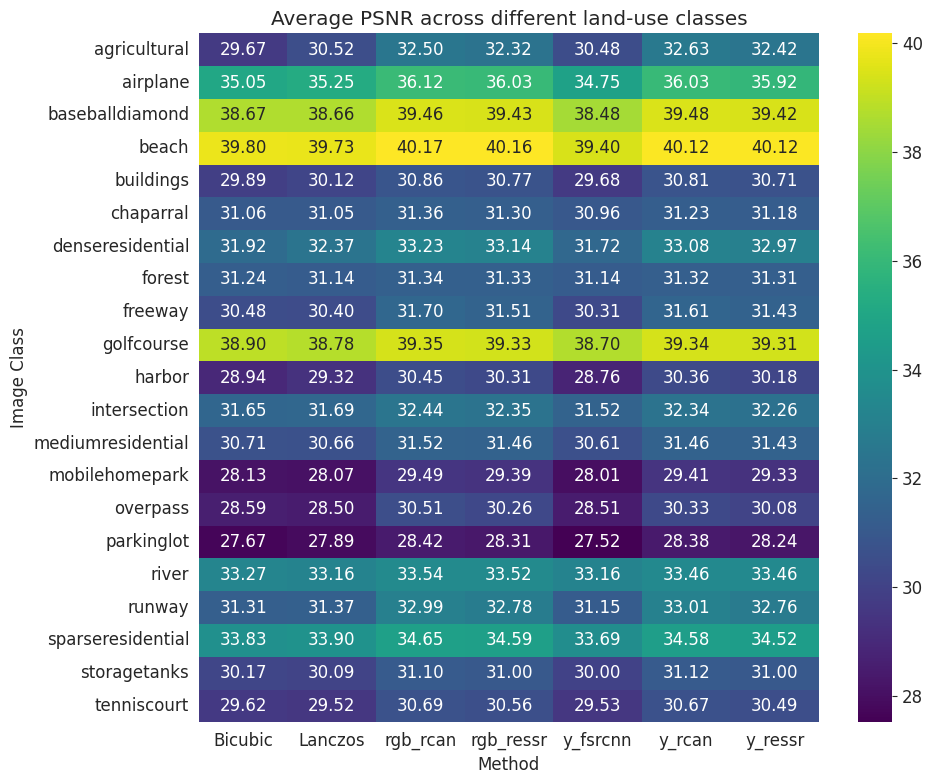

In [57]:
import matplotlib.pyplot as plt

class_psnr_pivot = df.groupby(['Class', 'Method'])['PSNR'].mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(
    class_psnr_pivot,
    annot=True,
    fmt=".2f",
    cmap="viridis"
)
plt.title('Average PSNR across different land-use classes')
plt.xlabel('Method')
plt.ylabel('Image Class')
plt.tight_layout()
plt.show()

In [85]:
def visualize_all_methods(df, models, test_dir, class_to_visualize=None, zoom_size=144):
    if class_to_visualize:
        file_name = random.choice(df[df['Class'] == class_to_visualize]['File'].unique())
        img_path = test_dir / class_to_visualize / file_name
    else:
        file_name = random.choice(df['File'].unique())
        class_name = df[df['File'] == file_name]['Class'].iloc[0]
        img_path = test_dir / class_name / file_name

    print(f"File: {img_path}")

    df_image = df[df['File'] == img_path.name]
    psnr_scores = df_image.set_index('Method')['PSNR'].to_dict()

    with rasterio.open(img_path) as src:
        hr_raw = src.read()

    hr = np.transpose(hr_raw, (1, 2, 0)).astype(np.float32) / 255.0
    H, W, _ = hr.shape
    H_new, W_new = H - (H % SCALE), W - (W % SCALE)
    hr = hr[:H_new, :W_new, :]

    lr_h, lr_w = H_new // SCALE, W_new // SCALE
    lr = SR_bicubic(hr, lr_h, lr_w, preserve_range=True, output_dtype=np.float32)

    sr_images_dict = {
        'Original HR': hr,
        'Bicubic': SR_bicubic(lr, H_new, W_new, preserve_range=True, output_dtype=np.float32),
        'Lanczos': SR_lanczos(lr, H_new, W_new, preserve_range=True, output_dtype=np.float32)
    }
    for name, model in models.items():
        sr_images_dict[name] = get_model_prediction(lr, name, model, SCALE)

    top = random.randint(0, H_new - zoom_size)
    left = random.randint(0, W_new - zoom_size)

    method_order = ['Original HR'] + order

    num_methods = len(method_order)

    fig, axes = plt.subplots(2, num_methods, figsize=(num_methods * 3, 7))
    fig.suptitle(f"class: {img_path.parent.name})")

    for i, name in enumerate(method_order):
        full_img = sr_images_dict[name]
        crop_img = full_img[top:top + zoom_size, left:left + zoom_size, :]

        axes[0, i].imshow(full_img)
        axes[0, i].axis('off')
        axes[0, i].set_title(name)

        axes[1, i].imshow(crop_img)
        axes[1, i].axis('off')

        if name in psnr_scores:
            axes[1, i].set_title(f"PSNR: {psnr_scores[name]:.2f} dB")
        else:
            axes[1, i].set_title("Zoom")

    rect = plt.Rectangle((left, top), zoom_size, zoom_size, linewidth=2, edgecolor='r', facecolor='none')
    axes[0, 0].add_patch(rect)

    plt.tight_layout()
    plt.show()

File: /home/aaa/.data/UCMerced_LandUse_Split/test/parkinglot/parkinglot53.tif


/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/mnt/c/Users/nicol/OneDrive/work/super-resolution/classic_algos/lanczos.py:4: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x))


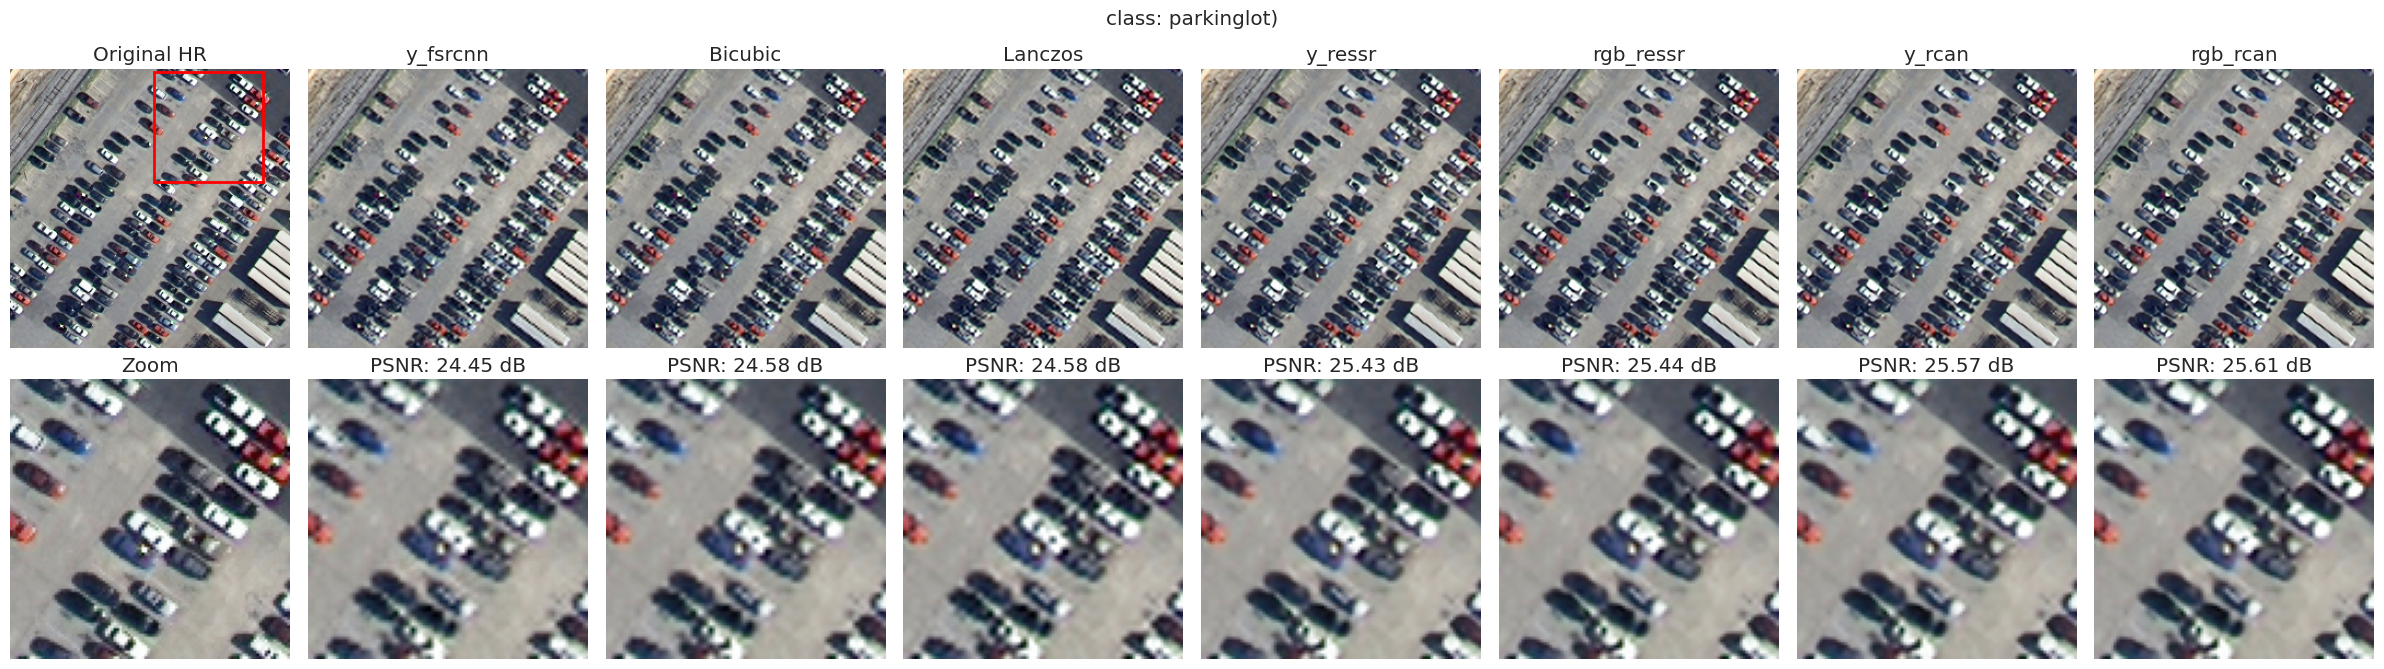

In [89]:
visualize_all_methods(df, models, TEST_DIR, zoom_size=100, class_to_visualize='parkinglot')

File: /home/aaa/.data/UCMerced_LandUse_Split/test/buildings/buildings26.tif


/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/mnt/c/Users/nicol/OneDrive/work/super-resolution/classic_algos/lanczos.py:4: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x))


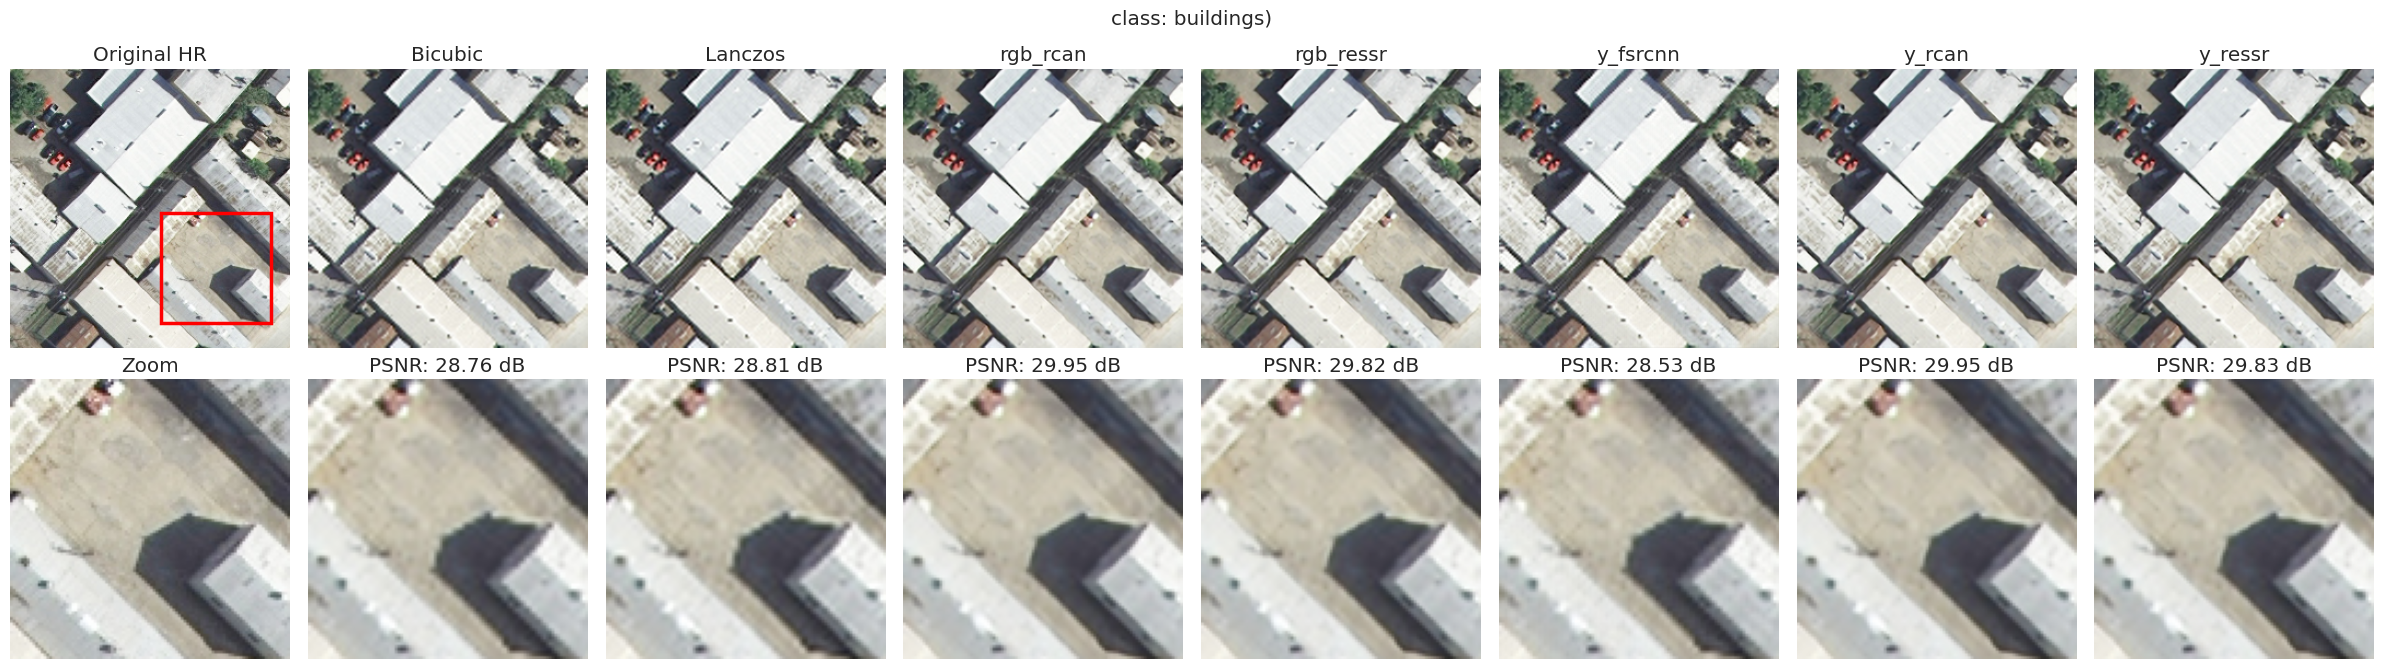

In [82]:
visualize_all_methods(df, models, TEST_DIR, class_to_visualize='buildings')

File: /home/aaa/.data/UCMerced_LandUse_Split/test/runway/runway73.tif


/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/mnt/c/Users/nicol/OneDrive/work/super-resolution/classic_algos/lanczos.py:4: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, 1.0, np.sin(np.pi * x) / (np.pi * x))


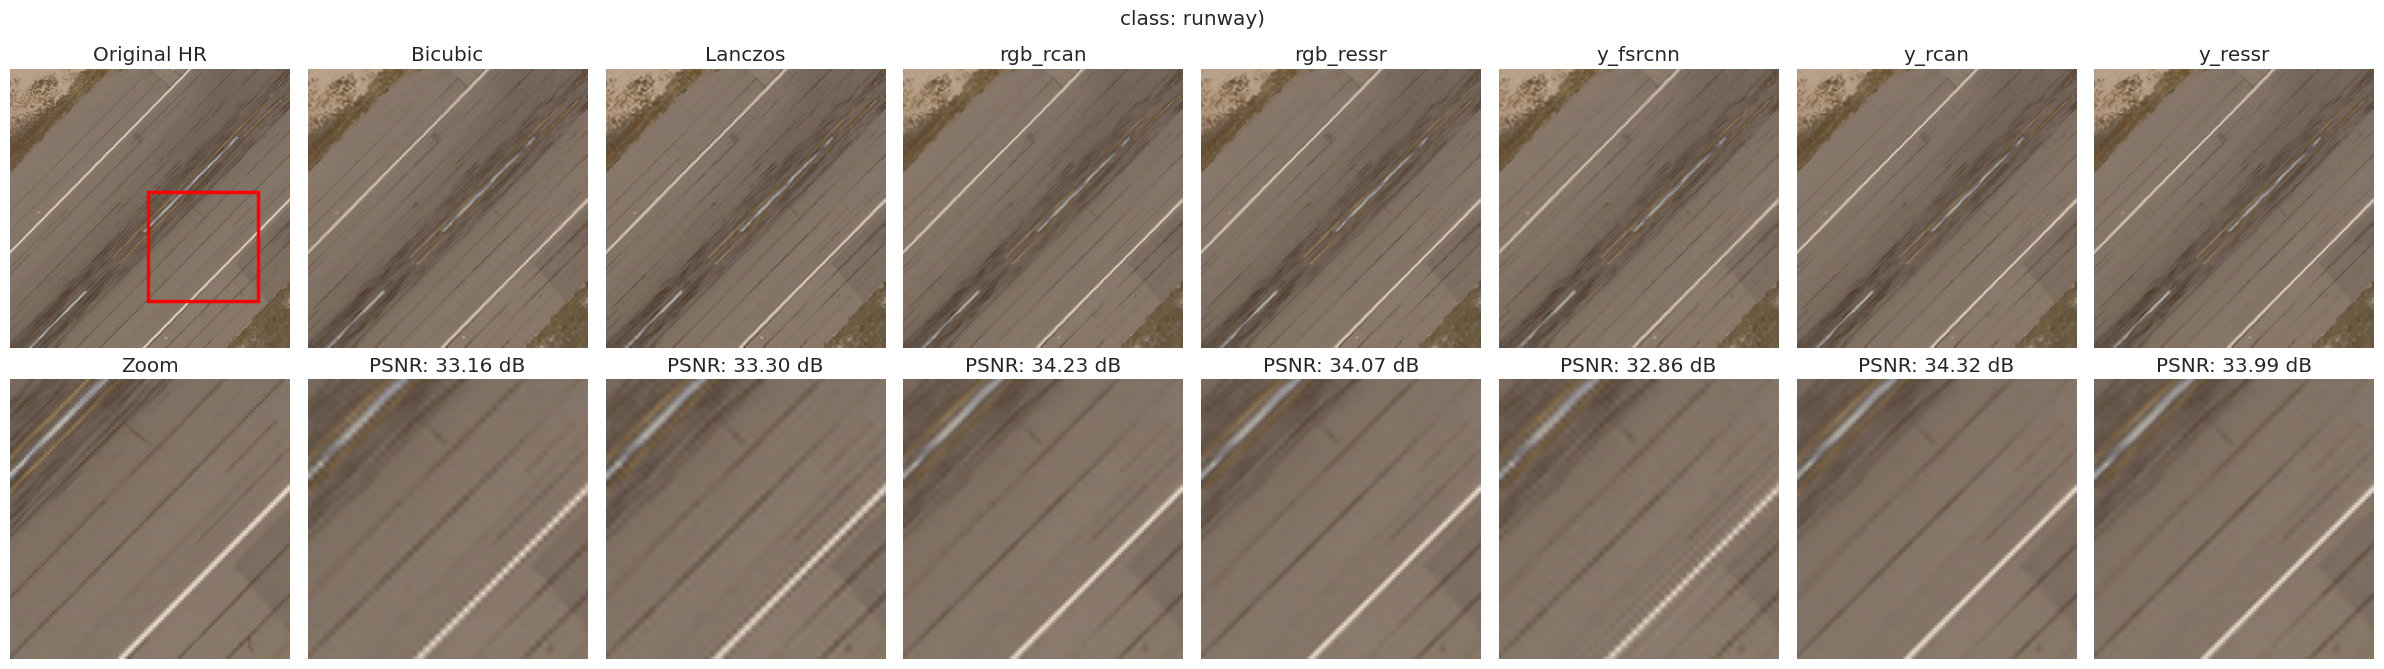

In [77]:
visualize_all_methods(df, models, TEST_DIR)